## 8. RAG (SQLite Database)

In this chapter we will perform RAG on an SQLite Database. We will use both approaches from the previous chapter: `RAG Chains` vs. `RAG Agents`

## 8.1 Setup

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langgraph

import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    load_dotenv()
except ImportError:
    pass

assert os.environ["LANGSMITH_TRACING"] is not None
assert os.environ["LANGSMITH_API_KEY"] is not None
assert os.environ["LANGSMITH_PROJECT"] is not None
assert os.environ["OPENAI_API_KEY"] is not None

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///example_data/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## 8.2 RAG Chain Approach

Chains are compositions of predictable steps. In LangGraph, we can represent a chain via simple sequence of nodes. Let's create a sequence of steps that, given a question, does the following:

1. converts the question into a SQL query;
2. executes the query;
3. uses the result to answer the original question.

**There are scenarios not supported by this arrangement**:

- For example, this system will execute a SQL query for any user input-- even "hello".
- Importantly, as we'll see below, **some questions require more than one query to answer. We will address these scenarios in the Agents section.**

In [3]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

The first step is to take the user input and convert it to a SQL query. To reliably obtain SQL queries (absent markdown formatting and explanations or clarifications), we will make use of LangChain's structured output abstraction.

In [4]:
%pip install -qU "langchain[openai]"
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

In [6]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

Let's test `write_query` before we continue:

In [7]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}

In [8]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [9]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

In [11]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

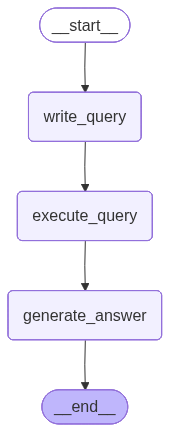

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

In [14]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


### 8.2.1 Human in the loop

LangGraph supports a number of features that can be useful for this workflow. One of them is human-in-the-loop: we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's persistence layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:

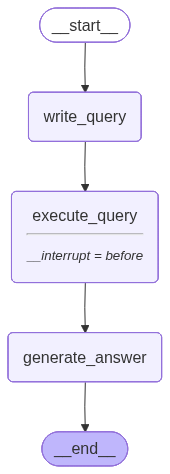

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) AS TotalEmployees FROM Employee;'}}
{'__interrupt__': ()}


Do you want to go to execute query? (yes/no):  Yes


{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are a total of 8 employees.'}}


## 8.3 RAG Agent

Agents leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allows you to offload additional discretion over the query generation and execution process. Although their behavior is less predictable than the above "chain", they feature some advantages:

- They can query the database as many times as needed to answer the user question.
- They can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
- They can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table).

We will create a ReAct agent equipped with the [SQLDatabaseToolkit](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html) includes tools that can:

- Create and execute queries
- Check query syntax
- Retrieve table descriptions
    ... and more

In [17]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1114f2660>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1114f2660>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1114f2660>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [21]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_VV30huRYjPeyeoa1F89uicLf)
 Call ID: call_VV30huRYjPeyeoa1F89uicLf
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_2vePWkfTnKWexBbO7rKds80a)
 Call ID: call_2vePWkfTnKWexBbO7rKds80a
  Args:
    table_names: Customer
  sql_db_schema (call_tkeBs7AjixbEvQOj9BYntoch)
 Call ID: call_tkeBs7AjixbEvQOj9BYntoch
  Args:
    table_names: Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Invoice" (
	"Inv

Note that the agent executes multiple queries until it has the information it needs:

- List available tables;
- Retrieves the schema for three tables;
- Queries multiple of the tables via a join operation.

The agent is then able to use the result of the final query to generate an answer to the original question.

The agent can similarly handle qualitative questions:

In [22]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_o3AekVQUyVNBCQbjPExpmEwW)
 Call ID: call_o3AekVQUyVNBCQbjPExpmEwW
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_mn9qtnEhVAPMve2i9vDz17qU)
 Call ID: call_mn9qtnEhVAPMve2i9vDz17qU
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackI

### 8.3.1 High Cardinality Columns

High Cardinality columns are columns that contain many distinct values. 
- A `full_name` column is an example of a high cardinality column
- `is_verified` is a low cardinality column.

In order to filter columns that contain proper nouns such as addresses, song names or artists, we first need to double-check the spelling in order to filter the data correctly.

We can achieve this by creating a vector store with all the distinct proper nouns that exist in the database. We can then have the agent query that vector store each time the user includes a proper noun in their question, to find the correct spelling for that word. In this way, the agent can make sure it understands which entity the user is referring to before building the target query.

In [23]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['Cesta Básica',
 'Sambas De Enredo',
 'The Colour And The Shape',
 'Santana Live',
 'Let There Be Rock']

In [27]:
import getpass
import os
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.agents.agent_toolkits import create_retriever_tool

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Jagged Little Pill

Angel Dust

Amy Winehouse


In [28]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

In [29]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_dgBx8AqB1DeOcaHoXYu7pjNg)
 Call ID: call_dgBx8AqB1DeOcaHoXYu7pjNg
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_71nntpTZQOKeQdmkfcwDvk24)
 Call ID: call_71nntpTZQOKeQdmkfcwDvk24
  Args:
    table_names: Album, Artist
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	F